<a href="https://colab.research.google.com/github/rachanashinde15/DemoGIt/blob/master/resnet_thesis_final_3_layerfinaloutputNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import datasets,models,layers


In [2]:
# Adding TF Cifar10 Data ..
from tensorflow.keras.datasets import cifar100
(X_train, Y_train), (X_test, Y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 11s 0us/step


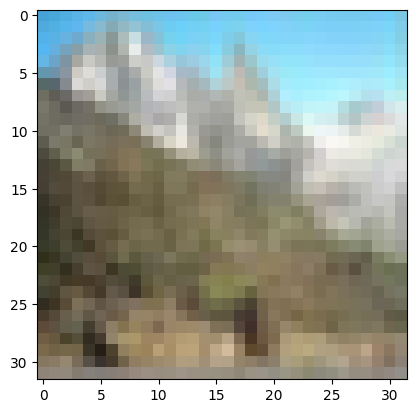

In [3]:
# Drawing sample .
plt.imshow(X_train[42])

In [4]:
# Normalize the data.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [6]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1 = ResnetBlock(64)
        self.res_2 = ResnetBlock(128, down_sample=True)
        self.res_3 = ResnetBlock(256, down_sample=True)
        self.res_4 = ResnetBlock(512, down_sample=True)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)

        # Group the consecutive residual blocks
        out = self.res_1(out)
        out = self.res_2(out)
        out = self.res_3(out)
        out = self.res_4(out)

        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out


In [9]:
model = ResNet18(100)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBlock  multiple              

Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 3.5761 - accuracy: 0.1686

156/156 [==============================] - 45s 158ms/step - loss: 3.5761 - accuracy: 0.1686 - val_loss: 5.5772 - val_accuracy: 0.0515
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 2.9094 - accuracy: 0.2791

156/156 [==============================] - 22s 142ms/step - loss: 2.9094 - accuracy: 0.2791 - val_loss: 3.2640 - val_accuracy: 0.2243
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 2.5698 - accuracy: 0.3414

156/156 [==============================] - 21s 137ms/step - loss: 2.5698 - accuracy: 0.3414 - val_loss: 3.1952 - val_accuracy: 0.2522
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 2.3338 - accuracy: 0.3892

156/156 [==============================] - 22s 142ms/step - loss: 2.3338 - accuracy: 0.3892 - val_loss: 2.2506 - val_accuracy: 0.4109
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 2.1286 - accuracy: 0.4362

156/156 [==============================] - 22s 141ms/step - loss: 2.1286 - accuracy: 0.4362 - val_loss: 2.2335 - val_accuracy: 0.4220
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 1.9592 - accuracy: 0.4700

156/156 [==============================] - 22s 144ms/step - loss: 1.9592 - accuracy: 0.4700 - val_loss: 2.0906 - val_accuracy: 0.4425
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 1.8043 - accuracy: 0.5070

156/156 [==============================] - 21s 136ms/step - loss: 1.8043 - accuracy: 0.5070 - val_loss: 1.8243 - val_accuracy: 0.5023
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 1.6586 - accuracy: 0.5412

156/156 [==============================] - 22s 143ms/step - loss: 1.6586 - accuracy: 0.5412 - val_loss: 1.4786 - val_accuracy: 0.5846
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 1.5277 - accuracy: 0.5758

156/156 [==============================] - 22s 143ms/step - loss: 1.5277 - accuracy: 0.5758 - val_loss: 1.4838 - val_accuracy: 0.5782
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 1.4013 - accuracy: 0.6039

156/156 [==============================] - 23s 144ms/step - loss: 1.4013 - accuracy: 0.6039 - val_loss: 1.7025 - val_accuracy: 0.5412
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 1.2741 - accuracy: 0.6382

156/156 [==============================] - 21s 136ms/step - loss: 1.2741 - accuracy: 0.6382 - val_loss: 1.1759 - val_accuracy: 0.6648
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 1.1602 - accuracy: 0.6643

156/156 [==============================] - 22s 143ms/step - loss: 1.1602 - accuracy: 0.6643 - val_loss: 1.0031 - val_accuracy: 0.7078
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 1.0442 - accuracy: 0.6961

156/156 [==============================] - 22s 141ms/step - loss: 1.0442 - accuracy: 0.6961 - val_loss: 1.3829 - val_accuracy: 0.6136
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.9431 - accuracy: 0.7235

156/156 [==============================] - 22s 141ms/step - loss: 0.9431 - accuracy: 0.7235 - val_loss: 0.7744 - val_accuracy: 0.7717
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.8433 - accuracy: 0.7499

156/156 [==============================] - 21s 137ms/step - loss: 0.8433 - accuracy: 0.7499 - val_loss: 0.7979 - val_accuracy: 0.7617
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.7613 - accuracy: 0.7725

156/156 [==============================] - 22s 141ms/step - loss: 0.7613 - accuracy: 0.7725 - val_loss: 0.7332 - val_accuracy: 0.7806
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.6717 - accuracy: 0.7979

156/156 [==============================] - 23s 144ms/step - loss: 0.6717 - accuracy: 0.7979 - val_loss: 0.6619 - val_accuracy: 0.7970
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.8137

156/156 [==============================] - 22s 143ms/step - loss: 0.6141 - accuracy: 0.8137 - val_loss: 0.6260 - val_accuracy: 0.8087
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.5546 - accuracy: 0.8310

156/156 [==============================] - 22s 141ms/step - loss: 0.5546 - accuracy: 0.8310 - val_loss: 0.4849 - val_accuracy: 0.8539
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.5006 - accuracy: 0.8487

156/156 [==============================] - 21s 136ms/step - loss: 0.5006 - accuracy: 0.8487 - val_loss: 0.6909 - val_accuracy: 0.7950
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.8664

156/156 [==============================] - 23s 150ms/step - loss: 0.4363 - accuracy: 0.8664 - val_loss: 0.7000 - val_accuracy: 0.7875
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.4078 - accuracy: 0.8743

156/156 [==============================] - 22s 142ms/step - loss: 0.4078 - accuracy: 0.8743 - val_loss: 0.3146 - val_accuracy: 0.9033
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.8883

156/156 [==============================] - 21s 136ms/step - loss: 0.3714 - accuracy: 0.8883 - val_loss: 0.4070 - val_accuracy: 0.8715
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.8967

156/156 [==============================] - 22s 142ms/step - loss: 0.3345 - accuracy: 0.8967 - val_loss: 0.2399 - val_accuracy: 0.9283
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.9062

156/156 [==============================] - 22s 142ms/step - loss: 0.3057 - accuracy: 0.9062 - val_loss: 0.4407 - val_accuracy: 0.8636
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.9101

156/156 [==============================] - 22s 141ms/step - loss: 0.2904 - accuracy: 0.9101 - val_loss: 0.2488 - val_accuracy: 0.9225
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.2925 - accuracy: 0.9088

156/156 [==============================] - 22s 141ms/step - loss: 0.2925 - accuracy: 0.9088 - val_loss: 0.3751 - val_accuracy: 0.8814
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.2673 - accuracy: 0.9166

156/156 [==============================] - 22s 141ms/step - loss: 0.2673 - accuracy: 0.9166 - val_loss: 0.2703 - val_accuracy: 0.9151
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.9249

156/156 [==============================] - 21s 135ms/step - loss: 0.2436 - accuracy: 0.9249 - val_loss: 0.3190 - val_accuracy: 0.8995
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.9188

156/156 [==============================] - 22s 140ms/step - loss: 0.2571 - accuracy: 0.9188 - val_loss: 0.3587 - val_accuracy: 0.8870
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.2332 - accuracy: 0.9261

156/156 [==============================] - 22s 143ms/step - loss: 0.2332 - accuracy: 0.9261 - val_loss: 0.3434 - val_accuracy: 0.8914
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.9343

156/156 [==============================] - 22s 141ms/step - loss: 0.2084 - accuracy: 0.9343 - val_loss: 0.5715 - val_accuracy: 0.8299
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9384

156/156 [==============================] - 21s 134ms/step - loss: 0.1971 - accuracy: 0.9384 - val_loss: 0.1704 - val_accuracy: 0.9463
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.9339

156/156 [==============================] - 22s 139ms/step - loss: 0.2083 - accuracy: 0.9339 - val_loss: 0.3875 - val_accuracy: 0.8842
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.1960 - accuracy: 0.9373

156/156 [==============================] - 21s 137ms/step - loss: 0.1960 - accuracy: 0.9373 - val_loss: 0.3172 - val_accuracy: 0.8990
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9436

156/156 [==============================] - 21s 136ms/step - loss: 0.1786 - accuracy: 0.9436 - val_loss: 0.2141 - val_accuracy: 0.9314
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.1921 - accuracy: 0.9385

156/156 [==============================] - 21s 133ms/step - loss: 0.1921 - accuracy: 0.9385 - val_loss: 0.3616 - val_accuracy: 0.8892
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9423

156/156 [==============================] - 22s 138ms/step - loss: 0.1799 - accuracy: 0.9423 - val_loss: 0.1806 - val_accuracy: 0.9415
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.1730 - accuracy: 0.9446

156/156 [==============================] - 22s 138ms/step - loss: 0.1730 - accuracy: 0.9446 - val_loss: 0.1302 - val_accuracy: 0.9579
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.1780 - accuracy: 0.9428

156/156 [==============================] - 21s 137ms/step - loss: 0.1780 - accuracy: 0.9428 - val_loss: 0.1719 - val_accuracy: 0.9441
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.1625 - accuracy: 0.9480

156/156 [==============================] - 23s 147ms/step - loss: 0.1625 - accuracy: 0.9480 - val_loss: 0.3751 - val_accuracy: 0.8863
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9457

156/156 [==============================] - 22s 143ms/step - loss: 0.1671 - accuracy: 0.9457 - val_loss: 0.1872 - val_accuracy: 0.9392
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.9533

156/156 [==============================] - 21s 135ms/step - loss: 0.1476 - accuracy: 0.9533 - val_loss: 0.3593 - val_accuracy: 0.8928
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.9463

156/156 [==============================] - 22s 142ms/step - loss: 0.1688 - accuracy: 0.9463 - val_loss: 0.2444 - val_accuracy: 0.9231
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9494

156/156 [==============================] - 21s 137ms/step - loss: 0.1586 - accuracy: 0.9494 - val_loss: 0.2618 - val_accuracy: 0.9173
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9494

156/156 [==============================] - 22s 142ms/step - loss: 0.1573 - accuracy: 0.9494 - val_loss: 0.2173 - val_accuracy: 0.9303
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.9576

156/156 [==============================] - 22s 142ms/step - loss: 0.1287 - accuracy: 0.9576 - val_loss: 0.2853 - val_accuracy: 0.9130
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9547

156/156 [==============================] - 22s 142ms/step - loss: 0.1423 - accuracy: 0.9547 - val_loss: 0.2281 - val_accuracy: 0.9296
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9520

156/156 [==============================] - 21s 136ms/step - loss: 0.1502 - accuracy: 0.9520 - val_loss: 0.2585 - val_accuracy: 0.9189
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9585

156/156 [==============================] - 22s 142ms/step - loss: 0.1294 - accuracy: 0.9585 - val_loss: 0.1522 - val_accuracy: 0.9510
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9571

156/156 [==============================] - 22s 144ms/step - loss: 0.1349 - accuracy: 0.9571 - val_loss: 0.1188 - val_accuracy: 0.9619
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9568

156/156 [==============================] - 21s 137ms/step - loss: 0.1366 - accuracy: 0.9568 - val_loss: 0.2164 - val_accuracy: 0.9313
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.9567

156/156 [==============================] - 23s 144ms/step - loss: 0.1358 - accuracy: 0.9567 - val_loss: 0.1889 - val_accuracy: 0.9391
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9536

156/156 [==============================] - 22s 142ms/step - loss: 0.1442 - accuracy: 0.9536 - val_loss: 0.1991 - val_accuracy: 0.9368
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9581

156/156 [==============================] - 21s 135ms/step - loss: 0.1318 - accuracy: 0.9581 - val_loss: 0.1907 - val_accuracy: 0.9393
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.9591

156/156 [==============================] - 22s 140ms/step - loss: 0.1278 - accuracy: 0.9591 - val_loss: 0.2600 - val_accuracy: 0.9200
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9609

156/156 [==============================] - 21s 134ms/step - loss: 0.1205 - accuracy: 0.9609 - val_loss: 0.0928 - val_accuracy: 0.9704
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.9694

156/156 [==============================] - 22s 142ms/step - loss: 0.0984 - accuracy: 0.9694 - val_loss: 1.4043 - val_accuracy: 0.7389
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.9629

156/156 [==============================] - 21s 133ms/step - loss: 0.1155 - accuracy: 0.9629 - val_loss: 0.1859 - val_accuracy: 0.9415
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9596

156/156 [==============================] - 22s 140ms/step - loss: 0.1222 - accuracy: 0.9596 - val_loss: 0.1989 - val_accuracy: 0.9348
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9636

156/156 [==============================] - 23s 148ms/step - loss: 0.1142 - accuracy: 0.9636 - val_loss: 0.0722 - val_accuracy: 0.9775
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.9623

156/156 [==============================] - 22s 139ms/step - loss: 0.1150 - accuracy: 0.9623 - val_loss: 0.3463 - val_accuracy: 0.8953
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9619

156/156 [==============================] - 22s 140ms/step - loss: 0.1189 - accuracy: 0.9619 - val_loss: 0.5863 - val_accuracy: 0.8494
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.9614

156/156 [==============================] - 22s 140ms/step - loss: 0.1199 - accuracy: 0.9614 - val_loss: 0.3773 - val_accuracy: 0.8934
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 0.9607

156/156 [==============================] - 21s 134ms/step - loss: 0.1196 - accuracy: 0.9607 - val_loss: 0.0685 - val_accuracy: 0.9781
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9660

156/156 [==============================] - 22s 142ms/step - loss: 0.1040 - accuracy: 0.9660 - val_loss: 0.0701 - val_accuracy: 0.9782
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9695

156/156 [==============================] - 22s 141ms/step - loss: 0.0953 - accuracy: 0.9695 - val_loss: 0.0817 - val_accuracy: 0.9739
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9722

156/156 [==============================] - 21s 135ms/step - loss: 0.0882 - accuracy: 0.9722 - val_loss: 0.1383 - val_accuracy: 0.9547
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9751

156/156 [==============================] - 22s 141ms/step - loss: 0.0781 - accuracy: 0.9751 - val_loss: 0.0850 - val_accuracy: 0.9726
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9679

156/156 [==============================] - 21s 136ms/step - loss: 0.0995 - accuracy: 0.9679 - val_loss: 0.2051 - val_accuracy: 0.9356
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9661

156/156 [==============================] - 21s 137ms/step - loss: 0.1050 - accuracy: 0.9661 - val_loss: 0.3564 - val_accuracy: 0.8986
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9681

156/156 [==============================] - 22s 140ms/step - loss: 0.1005 - accuracy: 0.9681 - val_loss: 0.1067 - val_accuracy: 0.9655
Epoch 13/20
156/156 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9674

156/156 [==============================] - 22s 140ms/step - loss: 0.0987 - accuracy: 0.9675 - val_loss: 0.1775 - val_accuracy: 0.9431
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9643

156/156 [==============================] - 22s 141ms/step - loss: 0.1106 - accuracy: 0.9643 - val_loss: 0.0887 - val_accuracy: 0.9711
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9687

156/156 [==============================] - 22s 141ms/step - loss: 0.0961 - accuracy: 0.9687 - val_loss: 0.1977 - val_accuracy: 0.9392
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9664

156/156 [==============================] - 22s 140ms/step - loss: 0.0989 - accuracy: 0.9664 - val_loss: 0.1668 - val_accuracy: 0.9481
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 0.9684

156/156 [==============================] - 21s 135ms/step - loss: 0.0957 - accuracy: 0.9684 - val_loss: 0.1233 - val_accuracy: 0.9605
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9706

156/156 [==============================] - 22s 142ms/step - loss: 0.0895 - accuracy: 0.9706 - val_loss: 0.0672 - val_accuracy: 0.9791
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9714

156/156 [==============================] - 22s 141ms/step - loss: 0.0876 - accuracy: 0.9714 - val_loss: 0.1205 - val_accuracy: 0.9622
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9701

156/156 [==============================] - 22s 141ms/step - loss: 0.0938 - accuracy: 0.9701 - val_loss: 0.1195 - val_accuracy: 0.9632
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9709

156/156 [==============================] - 23s 148ms/step - loss: 0.0930 - accuracy: 0.9709 - val_loss: 0.1094 - val_accuracy: 0.9647
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9739

156/156 [==============================] - 21s 134ms/step - loss: 0.0808 - accuracy: 0.9739 - val_loss: 0.0933 - val_accuracy: 0.9694
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9755

156/156 [==============================] - 22s 141ms/step - loss: 0.0746 - accuracy: 0.9755 - val_loss: 0.7265 - val_accuracy: 0.8251
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9742

156/156 [==============================] - 22s 139ms/step - loss: 0.0807 - accuracy: 0.9742 - val_loss: 0.0875 - val_accuracy: 0.9718
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9778

156/156 [==============================] - 22s 143ms/step - loss: 0.0686 - accuracy: 0.9778 - val_loss: 0.1558 - val_accuracy: 0.9507
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9713

156/156 [==============================] - 22s 141ms/step - loss: 0.0862 - accuracy: 0.9713 - val_loss: 0.1464 - val_accuracy: 0.9554
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9720

156/156 [==============================] - 21s 136ms/step - loss: 0.0847 - accuracy: 0.9720 - val_loss: 0.0973 - val_accuracy: 0.9679
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 0.9741

156/156 [==============================] - 22s 142ms/step - loss: 0.0809 - accuracy: 0.9741 - val_loss: 0.1986 - val_accuracy: 0.9396
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9716

156/156 [==============================] - 22s 139ms/step - loss: 0.0884 - accuracy: 0.9716 - val_loss: 0.1307 - val_accuracy: 0.9576
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9727

156/156 [==============================] - 22s 142ms/step - loss: 0.0855 - accuracy: 0.9727 - val_loss: 0.1144 - val_accuracy: 0.9624
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9726

156/156 [==============================] - 22s 139ms/step - loss: 0.0838 - accuracy: 0.9726 - val_loss: 0.3820 - val_accuracy: 0.8986
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9732

156/156 [==============================] - 22s 139ms/step - loss: 0.0827 - accuracy: 0.9732 - val_loss: 0.2014 - val_accuracy: 0.9402
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9719

156/156 [==============================] - 22s 141ms/step - loss: 0.0835 - accuracy: 0.9719 - val_loss: 0.1184 - val_accuracy: 0.9625
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9750

156/156 [==============================] - 23s 144ms/step - loss: 0.0766 - accuracy: 0.9750 - val_loss: 0.1760 - val_accuracy: 0.9459
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9760

156/156 [==============================] - 22s 142ms/step - loss: 0.0715 - accuracy: 0.9760 - val_loss: 0.1840 - val_accuracy: 0.9433
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9775

156/156 [==============================] - 21s 136ms/step - loss: 0.0718 - accuracy: 0.9775 - val_loss: 0.0780 - val_accuracy: 0.9747
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9785

156/156 [==============================] - 22s 141ms/step - loss: 0.0648 - accuracy: 0.9785 - val_loss: 0.0541 - val_accuracy: 0.9820
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9746

156/156 [==============================] - 22s 141ms/step - loss: 0.0776 - accuracy: 0.9746 - val_loss: 0.1041 - val_accuracy: 0.9663
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9783

156/156 [==============================] - 21s 135ms/step - loss: 0.0686 - accuracy: 0.9783 - val_loss: 0.0655 - val_accuracy: 0.9776
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9754

156/156 [==============================] - 22s 141ms/step - loss: 0.0769 - accuracy: 0.9754 - val_loss: 0.0471 - val_accuracy: 0.9840
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9782

156/156 [==============================] - 23s 148ms/step - loss: 0.0676 - accuracy: 0.9782 - val_loss: 0.0626 - val_accuracy: 0.9792
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9787

156/156 [==============================] - 21s 135ms/step - loss: 0.0656 - accuracy: 0.9787 - val_loss: 0.1384 - val_accuracy: 0.9561
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9808

156/156 [==============================] - 22s 141ms/step - loss: 0.0596 - accuracy: 0.9808 - val_loss: 0.1394 - val_accuracy: 0.9582
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9756

156/156 [==============================] - 21s 137ms/step - loss: 0.0729 - accuracy: 0.9756 - val_loss: 0.1930 - val_accuracy: 0.9404
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9772

156/156 [==============================] - 22s 142ms/step - loss: 0.0693 - accuracy: 0.9772 - val_loss: 0.3909 - val_accuracy: 0.9022
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9777

156/156 [==============================] - 22s 139ms/step - loss: 0.0700 - accuracy: 0.9777 - val_loss: 0.0685 - val_accuracy: 0.9767
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9763

156/156 [==============================] - 21s 135ms/step - loss: 0.0751 - accuracy: 0.9763 - val_loss: 0.0718 - val_accuracy: 0.9768
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9757

156/156 [==============================] - 22s 141ms/step - loss: 0.0776 - accuracy: 0.9757 - val_loss: 0.0543 - val_accuracy: 0.9824
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9780

156/156 [==============================] - 22s 140ms/step - loss: 0.0685 - accuracy: 0.9780 - val_loss: 0.1175 - val_accuracy: 0.9627
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9788

156/156 [==============================] - 22s 142ms/step - loss: 0.0638 - accuracy: 0.9788 - val_loss: 0.5820 - val_accuracy: 0.8662
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9794

156/156 [==============================] - 21s 135ms/step - loss: 0.0661 - accuracy: 0.9794 - val_loss: 0.1483 - val_accuracy: 0.9550
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9775

156/156 [==============================] - 22s 142ms/step - loss: 0.0696 - accuracy: 0.9775 - val_loss: 0.1471 - val_accuracy: 0.9544
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9778

156/156 [==============================] - 22s 140ms/step - loss: 0.0687 - accuracy: 0.9778 - val_loss: 0.0488 - val_accuracy: 0.9842
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9789

156/156 [==============================] - 22s 142ms/step - loss: 0.0629 - accuracy: 0.9789 - val_loss: 0.0601 - val_accuracy: 0.9797
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9819

156/156 [==============================] - 22s 139ms/step - loss: 0.0552 - accuracy: 0.9819 - val_loss: 0.1185 - val_accuracy: 0.9632
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9805

156/156 [==============================] - 22s 142ms/step - loss: 0.0596 - accuracy: 0.9805 - val_loss: 0.0443 - val_accuracy: 0.9858
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9828

156/156 [==============================] - 22s 141ms/step - loss: 0.0529 - accuracy: 0.9828 - val_loss: 0.2804 - val_accuracy: 0.9228
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9808

156/156 [==============================] - 22s 144ms/step - loss: 0.0601 - accuracy: 0.9808 - val_loss: 0.0862 - val_accuracy: 0.9726
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9798

156/156 [==============================] - 21s 134ms/step - loss: 0.0623 - accuracy: 0.9798 - val_loss: 0.1723 - val_accuracy: 0.9482
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9801

156/156 [==============================] - 22s 141ms/step - loss: 0.0597 - accuracy: 0.9801 - val_loss: 0.0726 - val_accuracy: 0.9758
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9814

156/156 [==============================] - 23s 148ms/step - loss: 0.0578 - accuracy: 0.9814 - val_loss: 0.0422 - val_accuracy: 0.9868
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9818

156/156 [==============================] - 22s 144ms/step - loss: 0.0578 - accuracy: 0.9818 - val_loss: 0.0936 - val_accuracy: 0.9715
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9806

156/156 [==============================] - 21s 136ms/step - loss: 0.0631 - accuracy: 0.9806 - val_loss: 0.0709 - val_accuracy: 0.9772
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9808

156/156 [==============================] - 22s 141ms/step - loss: 0.0599 - accuracy: 0.9808 - val_loss: 0.2275 - val_accuracy: 0.9366
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9805

156/156 [==============================] - 22s 142ms/step - loss: 0.0591 - accuracy: 0.9805 - val_loss: 0.2652 - val_accuracy: 0.9255
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9785

156/156 [==============================] - 21s 137ms/step - loss: 0.0684 - accuracy: 0.9785 - val_loss: 0.0769 - val_accuracy: 0.9762
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9778

156/156 [==============================] - 22s 141ms/step - loss: 0.0694 - accuracy: 0.9778 - val_loss: 0.1398 - val_accuracy: 0.9584
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9769

156/156 [==============================] - 23s 147ms/step - loss: 0.0721 - accuracy: 0.9769 - val_loss: 0.1538 - val_accuracy: 0.9535
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9786

156/156 [==============================] - 21s 137ms/step - loss: 0.0647 - accuracy: 0.9786 - val_loss: 0.0419 - val_accuracy: 0.9866
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9841

156/156 [==============================] - 22s 142ms/step - loss: 0.0501 - accuracy: 0.9841 - val_loss: 0.2427 - val_accuracy: 0.9336
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9844

156/156 [==============================] - 22s 141ms/step - loss: 0.0505 - accuracy: 0.9844 - val_loss: 0.2452 - val_accuracy: 0.9285
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9826

156/156 [==============================] - 21s 135ms/step - loss: 0.0547 - accuracy: 0.9826 - val_loss: 0.0945 - val_accuracy: 0.9718
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9819

156/156 [==============================] - 22s 139ms/step - loss: 0.0557 - accuracy: 0.9819 - val_loss: 0.0633 - val_accuracy: 0.9798
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9833

156/156 [==============================] - 22s 143ms/step - loss: 0.0526 - accuracy: 0.9833 - val_loss: 0.4007 - val_accuracy: 0.9105
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9841

156/156 [==============================] - 22s 143ms/step - loss: 0.0480 - accuracy: 0.9841 - val_loss: 0.0475 - val_accuracy: 0.9843
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9852

156/156 [==============================] - 23s 145ms/step - loss: 0.0462 - accuracy: 0.9852 - val_loss: 0.0368 - val_accuracy: 0.9877
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9855

156/156 [==============================] - 21s 137ms/step - loss: 0.0462 - accuracy: 0.9855 - val_loss: 0.1066 - val_accuracy: 0.9668
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9810

156/156 [==============================] - 22s 142ms/step - loss: 0.0550 - accuracy: 0.9810 - val_loss: 0.1267 - val_accuracy: 0.9603
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9797

156/156 [==============================] - 22s 142ms/step - loss: 0.0643 - accuracy: 0.9797 - val_loss: 0.2728 - val_accuracy: 0.9219
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9814

156/156 [==============================] - 22s 142ms/step - loss: 0.0577 - accuracy: 0.9814 - val_loss: 0.0872 - val_accuracy: 0.9722
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9809

156/156 [==============================] - 24s 153ms/step - loss: 0.0591 - accuracy: 0.9809 - val_loss: 0.1294 - val_accuracy: 0.9599
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9814

156/156 [==============================] - 21s 137ms/step - loss: 0.0580 - accuracy: 0.9814 - val_loss: 0.0381 - val_accuracy: 0.9879
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9818

156/156 [==============================] - 22s 143ms/step - loss: 0.0552 - accuracy: 0.9818 - val_loss: 0.1085 - val_accuracy: 0.9669
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9839

156/156 [==============================] - 21s 136ms/step - loss: 0.0490 - accuracy: 0.9839 - val_loss: 0.2287 - val_accuracy: 0.9378
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9847

156/156 [==============================] - 22s 143ms/step - loss: 0.0460 - accuracy: 0.9847 - val_loss: 0.0386 - val_accuracy: 0.9881
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9846

156/156 [==============================] - 22s 143ms/step - loss: 0.0487 - accuracy: 0.9846 - val_loss: 0.0649 - val_accuracy: 0.9797
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9843

156/156 [==============================] - 22s 142ms/step - loss: 0.0483 - accuracy: 0.9843 - val_loss: 0.0502 - val_accuracy: 0.9841
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9824

156/156 [==============================] - 21s 137ms/step - loss: 0.0538 - accuracy: 0.9824 - val_loss: 0.0966 - val_accuracy: 0.9700
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9827

156/156 [==============================] - 22s 140ms/step - loss: 0.0547 - accuracy: 0.9827 - val_loss: 0.0283 - val_accuracy: 0.9902
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9847

156/156 [==============================] - 22s 142ms/step - loss: 0.0475 - accuracy: 0.9847 - val_loss: 0.0780 - val_accuracy: 0.9761
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9845

156/156 [==============================] - 21s 134ms/step - loss: 0.0488 - accuracy: 0.9845 - val_loss: 0.2564 - val_accuracy: 0.9319
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9847

156/156 [==============================] - 22s 142ms/step - loss: 0.0471 - accuracy: 0.9847 - val_loss: 0.4912 - val_accuracy: 0.8877
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9833

156/156 [==============================] - 23s 145ms/step - loss: 0.0503 - accuracy: 0.9833 - val_loss: 0.3262 - val_accuracy: 0.9160
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9834

156/156 [==============================] - 23s 146ms/step - loss: 0.0504 - accuracy: 0.9834 - val_loss: 0.0440 - val_accuracy: 0.9865
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9844

156/156 [==============================] - 23s 144ms/step - loss: 0.0477 - accuracy: 0.9844 - val_loss: 0.1032 - val_accuracy: 0.9691
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9859

156/156 [==============================] - 22s 140ms/step - loss: 0.0443 - accuracy: 0.9859 - val_loss: 0.0299 - val_accuracy: 0.9902
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9838

156/156 [==============================] - 23s 144ms/step - loss: 0.0508 - accuracy: 0.9838 - val_loss: 0.0533 - val_accuracy: 0.9830
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9856

156/156 [==============================] - 22s 141ms/step - loss: 0.0447 - accuracy: 0.9856 - val_loss: 0.0611 - val_accuracy: 0.9811
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9850

156/156 [==============================] - 22s 142ms/step - loss: 0.0452 - accuracy: 0.9850 - val_loss: 0.0433 - val_accuracy: 0.9855
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9848

156/156 [==============================] - 23s 145ms/step - loss: 0.0476 - accuracy: 0.9848 - val_loss: 0.0206 - val_accuracy: 0.9930
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.9858

156/156 [==============================] - 24s 151ms/step - loss: 0.0435 - accuracy: 0.9858 - val_loss: 0.0363 - val_accuracy: 0.9881
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9853

156/156 [==============================] - 23s 146ms/step - loss: 0.0453 - accuracy: 0.9853 - val_loss: 0.1870 - val_accuracy: 0.9502
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9851

156/156 [==============================] - 23s 146ms/step - loss: 0.0472 - accuracy: 0.9851 - val_loss: 0.0498 - val_accuracy: 0.9845
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9841

156/156 [==============================] - 23s 145ms/step - loss: 0.0493 - accuracy: 0.9841 - val_loss: 0.3146 - val_accuracy: 0.9214
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.9855

156/156 [==============================] - 23s 146ms/step - loss: 0.0435 - accuracy: 0.9855 - val_loss: 0.1257 - val_accuracy: 0.9634
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9848

156/156 [==============================] - 23s 145ms/step - loss: 0.0488 - accuracy: 0.9848 - val_loss: 0.0584 - val_accuracy: 0.9804
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9846

156/156 [==============================] - 22s 140ms/step - loss: 0.0467 - accuracy: 0.9846 - val_loss: 0.1894 - val_accuracy: 0.9443
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9845

156/156 [==============================] - 22s 143ms/step - loss: 0.0468 - accuracy: 0.9845 - val_loss: 0.3233 - val_accuracy: 0.9230
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9841

156/156 [==============================] - 23s 146ms/step - loss: 0.0473 - accuracy: 0.9841 - val_loss: 0.1814 - val_accuracy: 0.9494
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9862

156/156 [==============================] - 22s 144ms/step - loss: 0.0423 - accuracy: 0.9862 - val_loss: 0.0848 - val_accuracy: 0.9732
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.0411 - accuracy: 0.9871

156/156 [==============================] - 22s 140ms/step - loss: 0.0411 - accuracy: 0.9871 - val_loss: 0.0328 - val_accuracy: 0.9895
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.0448 - accuracy: 0.9859

156/156 [==============================] - 23s 144ms/step - loss: 0.0448 - accuracy: 0.9859 - val_loss: 0.1481 - val_accuracy: 0.9572
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9840

156/156 [==============================] - 23s 145ms/step - loss: 0.0481 - accuracy: 0.9840 - val_loss: 0.0554 - val_accuracy: 0.9826
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9854

156/156 [==============================] - 23s 146ms/step - loss: 0.0453 - accuracy: 0.9854 - val_loss: 0.1067 - val_accuracy: 0.9674
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9858

156/156 [==============================] - 22s 140ms/step - loss: 0.0438 - accuracy: 0.9858 - val_loss: 0.0715 - val_accuracy: 0.9768
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9875

156/156 [==============================] - 22s 142ms/step - loss: 0.0390 - accuracy: 0.9875 - val_loss: 0.0708 - val_accuracy: 0.9783
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9866

156/156 [==============================] - 22s 143ms/step - loss: 0.0433 - accuracy: 0.9866 - val_loss: 0.2142 - val_accuracy: 0.9395
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9858

156/156 [==============================] - 21s 135ms/step - loss: 0.0419 - accuracy: 0.9858 - val_loss: 0.0487 - val_accuracy: 0.9840
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9847

156/156 [==============================] - 22s 143ms/step - loss: 0.0472 - accuracy: 0.9847 - val_loss: 0.0797 - val_accuracy: 0.9765
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9855

156/156 [==============================] - 21s 136ms/step - loss: 0.0431 - accuracy: 0.9855 - val_loss: 0.0498 - val_accuracy: 0.9849
Epoch 1/20
157/156 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9869

156/156 [==============================] - 23s 150ms/step - loss: 0.0401 - accuracy: 0.9869 - val_loss: 0.0788 - val_accuracy: 0.9757
Epoch 2/20
157/156 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9876

156/156 [==============================] - 22s 142ms/step - loss: 0.0388 - accuracy: 0.9876 - val_loss: 0.0408 - val_accuracy: 0.9867
Epoch 3/20
157/156 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.9822

156/156 [==============================] - 22s 141ms/step - loss: 0.0568 - accuracy: 0.9822 - val_loss: 0.0493 - val_accuracy: 0.9851
Epoch 4/20
157/156 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9828

156/156 [==============================] - 22s 138ms/step - loss: 0.0538 - accuracy: 0.9828 - val_loss: 0.0307 - val_accuracy: 0.9894
Epoch 5/20
157/156 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9866

156/156 [==============================] - 22s 141ms/step - loss: 0.0406 - accuracy: 0.9866 - val_loss: 0.0374 - val_accuracy: 0.9876
Epoch 6/20
157/156 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9872

156/156 [==============================] - 22s 140ms/step - loss: 0.0415 - accuracy: 0.9872 - val_loss: 0.3710 - val_accuracy: 0.9123
Epoch 7/20
157/156 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9871

156/156 [==============================] - 22s 141ms/step - loss: 0.0400 - accuracy: 0.9871 - val_loss: 0.0178 - val_accuracy: 0.9945
Epoch 8/20
157/156 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9876

156/156 [==============================] - 22s 143ms/step - loss: 0.0377 - accuracy: 0.9876 - val_loss: 0.1397 - val_accuracy: 0.9626
Epoch 9/20
157/156 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9890

156/156 [==============================] - 21s 137ms/step - loss: 0.0346 - accuracy: 0.9890 - val_loss: 0.1247 - val_accuracy: 0.9633
Epoch 10/20
157/156 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9884

156/156 [==============================] - 22s 143ms/step - loss: 0.0372 - accuracy: 0.9884 - val_loss: 0.0809 - val_accuracy: 0.9746
Epoch 11/20
157/156 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9892

156/156 [==============================] - 22s 143ms/step - loss: 0.0336 - accuracy: 0.9892 - val_loss: 0.1615 - val_accuracy: 0.9566
Epoch 12/20
157/156 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9875

156/156 [==============================] - 22s 138ms/step - loss: 0.0385 - accuracy: 0.9875 - val_loss: 0.2316 - val_accuracy: 0.9401
Epoch 13/20
157/156 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9859

156/156 [==============================] - 22s 143ms/step - loss: 0.0423 - accuracy: 0.9859 - val_loss: 0.0776 - val_accuracy: 0.9760
Epoch 14/20
157/156 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.9862

156/156 [==============================] - 22s 144ms/step - loss: 0.0435 - accuracy: 0.9862 - val_loss: 0.2002 - val_accuracy: 0.9455
Epoch 15/20
157/156 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9870

156/156 [==============================] - 22s 140ms/step - loss: 0.0397 - accuracy: 0.9870 - val_loss: 0.1992 - val_accuracy: 0.9485
Epoch 16/20
157/156 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9877

156/156 [==============================] - 23s 145ms/step - loss: 0.0397 - accuracy: 0.9877 - val_loss: 0.1527 - val_accuracy: 0.9584
Epoch 17/20
157/156 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9872

156/156 [==============================] - 23s 144ms/step - loss: 0.0391 - accuracy: 0.9872 - val_loss: 0.4110 - val_accuracy: 0.9034
Epoch 18/20
157/156 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9876

156/156 [==============================] - 23s 146ms/step - loss: 0.0391 - accuracy: 0.9876 - val_loss: 0.0504 - val_accuracy: 0.9837
Epoch 19/20
157/156 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9874

156/156 [==============================] - 22s 139ms/step - loss: 0.0391 - accuracy: 0.9874 - val_loss: 0.0342 - val_accuracy: 0.9892
Epoch 20/20
157/156 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9878

156/156 [==============================] - 23s 144ms/step - loss: 0.0376 - accuracy: 0.9878 - val_loss: 0.0700 - val_accuracy: 0.9785


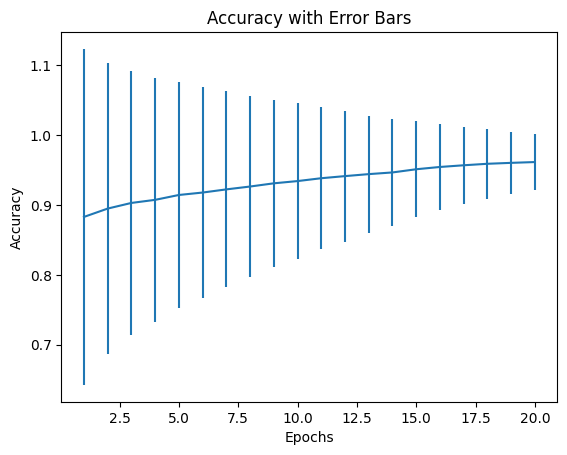

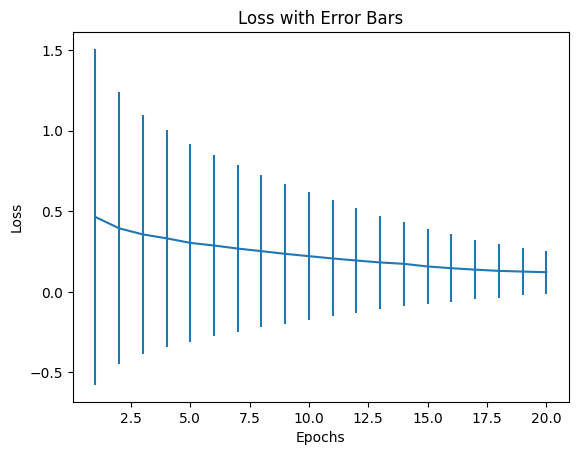

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Define the early stopping callback
es = EarlyStopping(patience=8, restore_best_weights=True, monitor="val_acc")
STEPS = len(X_train) / 256

# Create lists to store history objects
history_objects = []

# Loop over the training phases
for _ in range(10):
    # Train the model with early stopping callback
    history = model.fit(aug.flow(X_train, Y_train, batch_size=256),
                        steps_per_epoch=STEPS,
                        batch_size=256,
                        epochs=20,
                        validation_data=(X_train, Y_train),
                        callbacks=[es])

    # Store history object
    history_objects.append(history)

# Extract relevant metrics for plotting
accuracy_values = [history.history['accuracy'] for history in history_objects]
loss_values = [history.history['loss'] for history in history_objects]

# Calculate mean and standard deviation
mean_accuracy = np.mean(accuracy_values, axis=0)
std_accuracy = np.std(accuracy_values, axis=0)
mean_loss = np.mean(loss_values, axis=0)
std_loss = np.std(loss_values, axis=0)

def plot_model_history(metric_name, mean_values, std_values):
    epochs = range(1, len(mean_values) + 1)  # Create x-axis values for epochs
    plt.errorbar(epochs, mean_values, yerr=std_values)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} with Error Bars')
    plt.show()

plot_model_history('Accuracy', mean_accuracy, std_accuracy)
plot_model_history('Loss', mean_loss, std_loss)


In [11]:
#from tensorflow.keras.callbacks import EarlyStopping

#es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
#STEPS = len(X_train) / 256
#history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs=50, validation_data=(X_train, Y_train),callbacks=[es])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


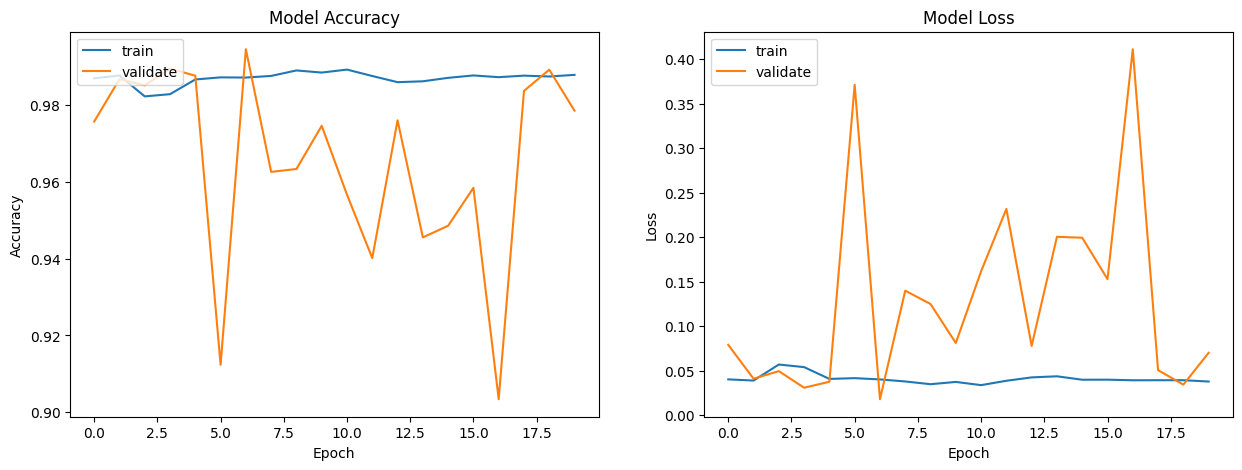

In [12]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')

    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [13]:

ModelLoss, ModelAccuracy = model.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 [==============================] - 6s 4ms/step - loss: 0.0700 - accuracy: 0.9785
Model Loss is 0.06995944678783417
Model Accuracy is 0.9785000085830688


In [14]:
# Assuming you have trained the model and stored it in the 'model' variable
from sklearn.metrics import confusion_matrix
# Make predictions on the test set
Y_pred = model.predict(X_test)
# Convert the one-hot encoded predictions and true labels to their original form
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test, axis=1)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(Y_true_labels, Y_pred_labels)
print("Confusion Matrix:")
print(confusion_mat)


313/313 [==============================] - 1s 4ms/step
Confusion Matrix:
[[66  0  0 ...  0  0  0]
 [ 0 62  0 ...  0  0  1]
 [ 0  1 25 ...  2  3  0]
 ...
 [ 0  0  0 ... 50  2  0]
 [ 1  1  2 ...  1 15  1]
 [ 0  0  1 ...  0  0 42]]


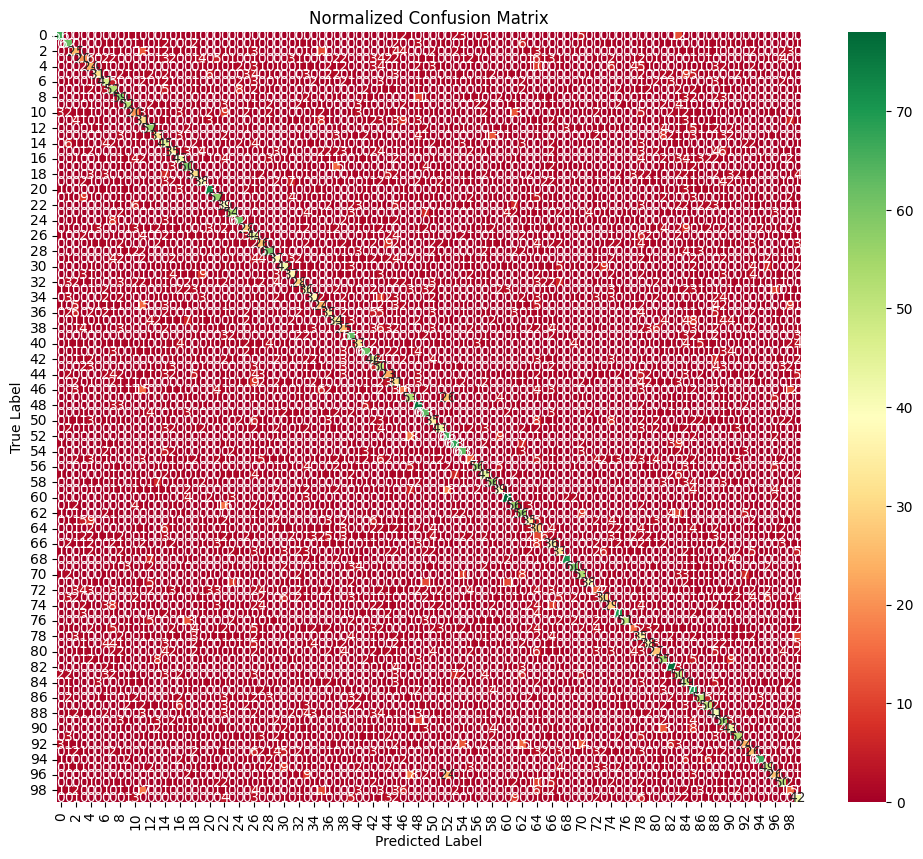

In [15]:
# Define class labels
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mat, annot=True, cmap='RdYlGn', fmt='d')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [16]:
from sklearn.metrics import classification_report

# Assuming you have the true labels 'y_true' and predicted labels 'y_pred'

# Generate classification report
report = classification_report(Y_pred_labels,Y_true_labels)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.66      0.78      0.71        85
           1       0.62      0.54      0.58       114
           2       0.25      0.30      0.27        84
           3       0.20      0.24      0.22        85
           4       0.24      0.25      0.24        96
           5       0.31      0.62      0.41        50
           6       0.47      0.46      0.46       103
           7       0.52      0.38      0.44       136
           8       0.59      0.47      0.52       125
           9       0.52      0.68      0.59        77
          10       0.20      0.29      0.24        68
          11       0.31      0.22      0.26       142
          12       0.57      0.52      0.55       109
          13       0.33      0.44      0.38        75
          14       0.45      0.31      0.37       144
          15       0.35      0.37      0.36        94
          16       0.43      0.49      0.46        87
          17       0.60    